In [1]:
import sys
import os

sys.path.append(os.getcwd())

import numpy as np
import refnx
from refnx.dataset import ReflectDataset
from refnx.analysis import Transform, CurveFitter, Objective, GlobalObjective, Parameter, possibly_create_parameter
from refnx.reflect import SLD, ReflectModel, MixedReflectModel, Slab, Structure, MixedSlab
from refnx.analysis.parameter import _BinaryOp
import scipy
import periodictable
import matplotlib.pyplot as plt
import dynesty
import pickle

from VFP_v0_0_1 import VFP

In [2]:
# SLDs
Si = SLD(2.07, name='Si')
SiO2 = SLD(3.47, name='SiO2')
Surfactant = SLD(0.1, name='Surf')
D2O = SLD(6.37, name='D2O')

In [3]:
# load in the data from the "Fitting with VFP" example.

fp_data = 'Fake_Si_data.dat'
Data = ReflectDataset(fp_data)

In [4]:
# parameters to fit

SiO2_thick = Parameter(20, name='SiO2_thick', vary=True, bounds=(10, 30))
SiO2_rough = Parameter(1, name='SiO2_rough', vary=True, bounds=(1, 10))

Surf_thick = Parameter(10, name='Surf_thick', vary=True, bounds=(10, 40))
Surf_rough = Parameter(1, name='Surf_rough', vary=True, bounds=(1, 10))
Surf_vf = Parameter(0.4, name='Surf_vf', vary=True, bounds=(0, 1))

# last interface will be conformal.
# Surf_D2O_R = Parameter(1, name='Surf_D2O_R', vary=True, bounds=(1, 10))

In [5]:
# init 2 lists of thickness and roughness parameters

list_of_thickness = (0, SiO2_thick, Surf_thick) # first must be zero for Si thickness.
list_of_roughness = (SiO2_rough, Surf_rough, 'conformal') # last interface is conformal.

In [6]:
"""
The nSLDs are ordered as the following:
Si, SiO2, Surfactant, D2O
"""

# these values can come from the layers defined above, the SLD objects above or some function of them.
nuclear_SLDs = np.array([Si.real, 
                         SiO2.real, 
                         (Surfactant.real*(1-Surf_vf)+D2O.real*Surf_vf),
                         D2O.real])

In [7]:
# we need to put any varying parameters that are part of an operation in the 
# nuclear_SLDs_fit/nuclear_iSLDs_fit/magnetic_SLDs_fit into auxiliary_parameters.

# Surf_lay.sld.real & D2O_lay.sld.real do not vary, but Surf_vf does so put it in auxiliary_parameters.
auxiliary_parameters = [Surf_vf]

In [8]:
# now define the VFP
d2o_vfp = VFP(nucSLDs=nuclear_SLDs, 
              thicknesses=list_of_thickness,
              roughnesses=list_of_roughness)

C:\Users\soo29949\OneDrive - Science and Technology Facilities Council\Git_repos\VFP\Examples\VFP_v0_0_1.py:181: UserWarning: Pass nucSLD parameters that are only part of a parameter operation (i.e f(p1, p2) = p1 + p2) to the auxiliary parameters argument of the objective.
  warnings.warn(


In [9]:
# wrap the vfp between the fronting and backing SLDs (not layers!)
d2o_struct = Si | d2o_vfp | D2O

In [10]:
intensity_p = Parameter(1, name='Intensity', vary=True, bounds=(0.8, 1.2))
bkg_p = Parameter(1e-6, name='bkg', vary=True, bounds=(1e-7, 1e-4))

In [11]:
VFP_model = ReflectModel(d2o_struct, scale=intensity_p, bkg=bkg_p, dq=3*2.355)

In [12]:
# remember to pass the auxiliary_parameters list to the objective

VFP_obj = Objective(VFP_model, Data, auxiliary_params=auxiliary_parameters)

glob_obj = GlobalObjective([VFP_obj])

In [13]:
 #We'll use dynesty to explore the combined prior & likelihood space

if __name__ == '__main__':
    sys.path.append(os.getcwd())
    from schwimmbad import MultiPool
    with MultiPool() as p:
        nested_sampler = dynesty.NestedSampler(glob_obj.logl, 
                                               glob_obj.prior_transform, 
                                               ndim=len(glob_obj.varying_parameters()), 
                                               nlive=500,
                                               sample='rslice',
                                               bound='multi',
                                               pool=p)
        nested_sampler.run_nested(dlogz=0.509, print_progress=True)
        p.close()
    res = nested_sampler.results
    print(res.logz[-1], res.logzerr[-1])
    print('Keys:', res.keys(),'\n')  # print accessible keys
    res.summary()  # print a summary

18519it [37:23,  8.26it/s, +500 | bound: 96 | nc: 1 | ncall: 965794 | eff(%):  1.970 | loglstar:   -inf < 959.058 <    inf | logz: 922.667 +/-  0.270 | dlogz:  0.001 >  0.509]    


922.6670946165273 0.4389380003291944
Keys: ['nlive', 'niter', 'ncall', 'eff', 'samples', 'blob', 'samples_id', 'samples_it', 'samples_u', 'logwt', 'logl', 'logvol', 'logz', 'logzerr', 'information', 'bound', 'bound_iter', 'samples_bound', 'scale'] 

Summary
nlive: 500
niter: 18519
ncall: 965294
eff(%):  1.970
logz: 922.667 +/-  0.439


In [14]:
# save the GO and NS results

with open('VFP_GO_conformal.pkl', 'wb+') as f:
    pickle.dump(glob_obj, f)

with open('VFP_NS_conformal.pkl', 'wb+') as f:
    pickle.dump(res, f)

In [15]:
# now open these results & analyse from there.

with open("VFP_GO_conformal.pkl","rb") as f:
	GO = pickle.load(f)
    
with open("VFP_NS_conformal.pkl","rb") as f:
	res_load = pickle.load(f)

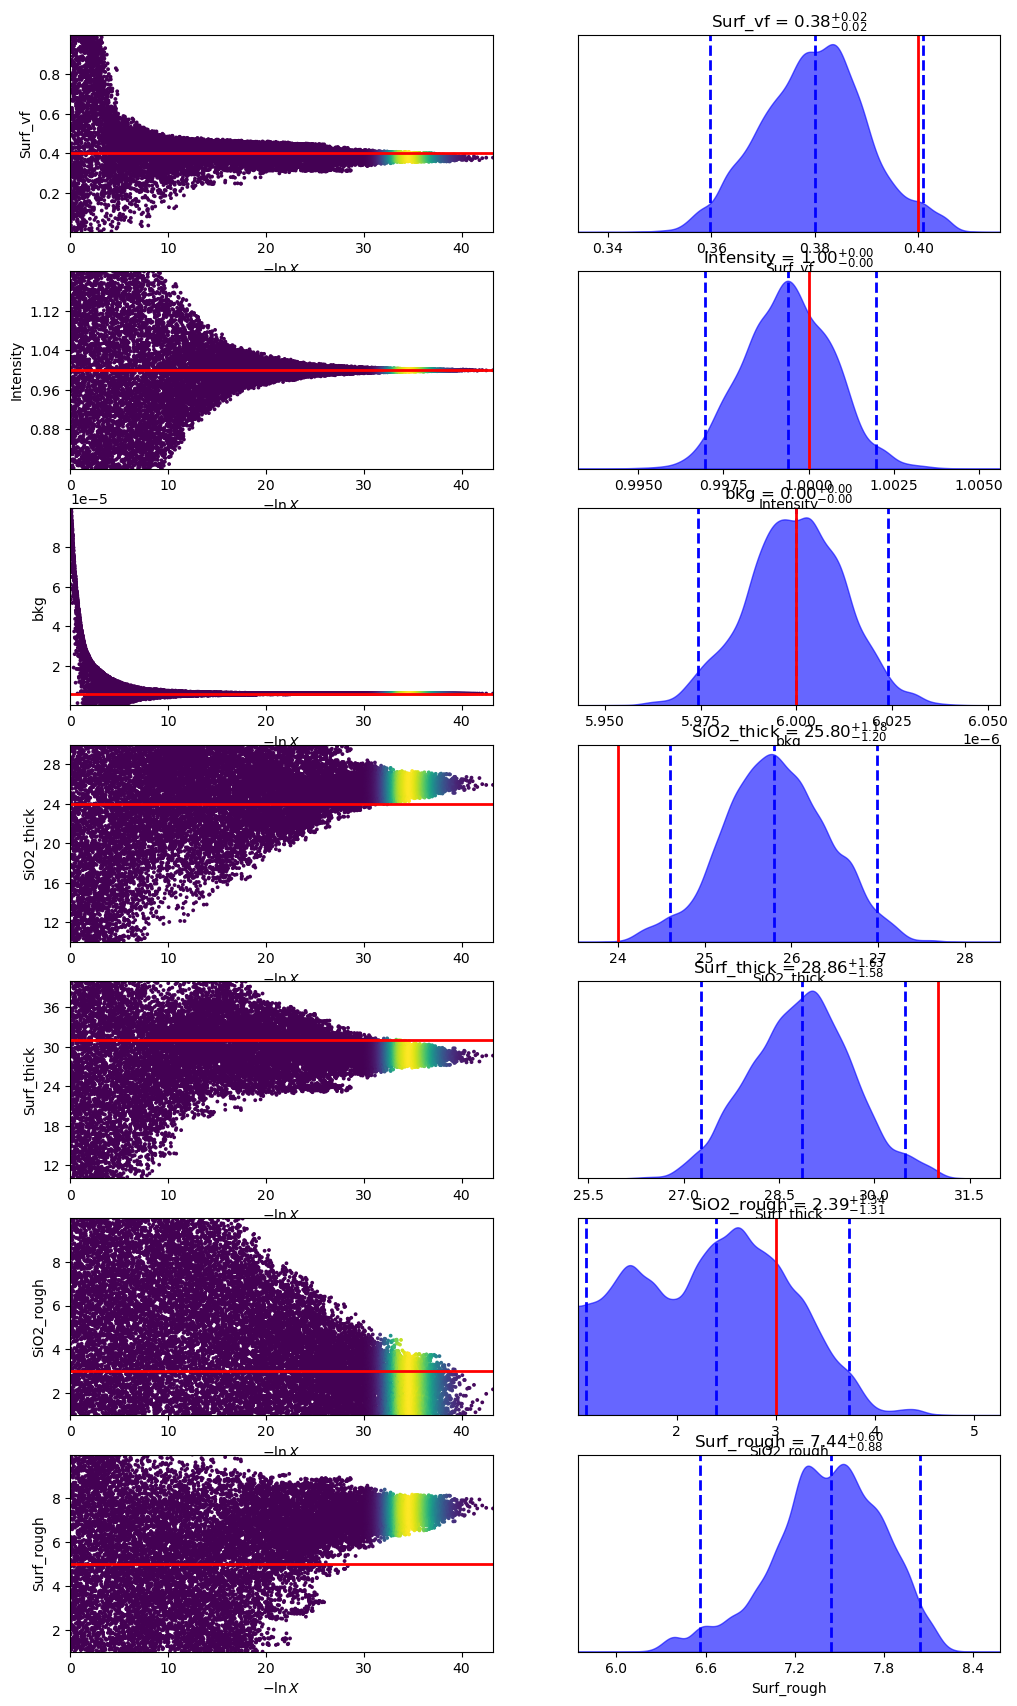

In [17]:
# take a look at the figure below
# the left hand side shows the evolution of the "dead" points (the points with the lowest likelihood @ each iteration) 
# while the right side shows the 1D posteriors (right), calculated from the combination of weights and dead points
# over the run. The red line shows the true value of the parameter.
# Coloured band in the dead points shows where the bulk of the posterior lies.

# notice the dead points for the bkg parameter are not uniformly spread at the start.
# this is because bkgs ~ 1e-4 & 1e-5 will significantly affect the likelihood (give you a very poor fit), 
# and so there is more of a noticable trend of the higher bkgs to be removed at very beginning.
# better prior choice would avoid having to sample these points that are clearly inappropriate, and speed up the sampling.

from dynesty import plotting as dyplot

labelz = GO.varying_parameters().names()
truthz = [0.4, 1, 6e-6, 24, 31, 3, 5]
fig, axes = dyplot.traceplot(res_load, show_titles=True, trace_cmap='viridis', labels=labelz, truths=truthz)
plt.show()

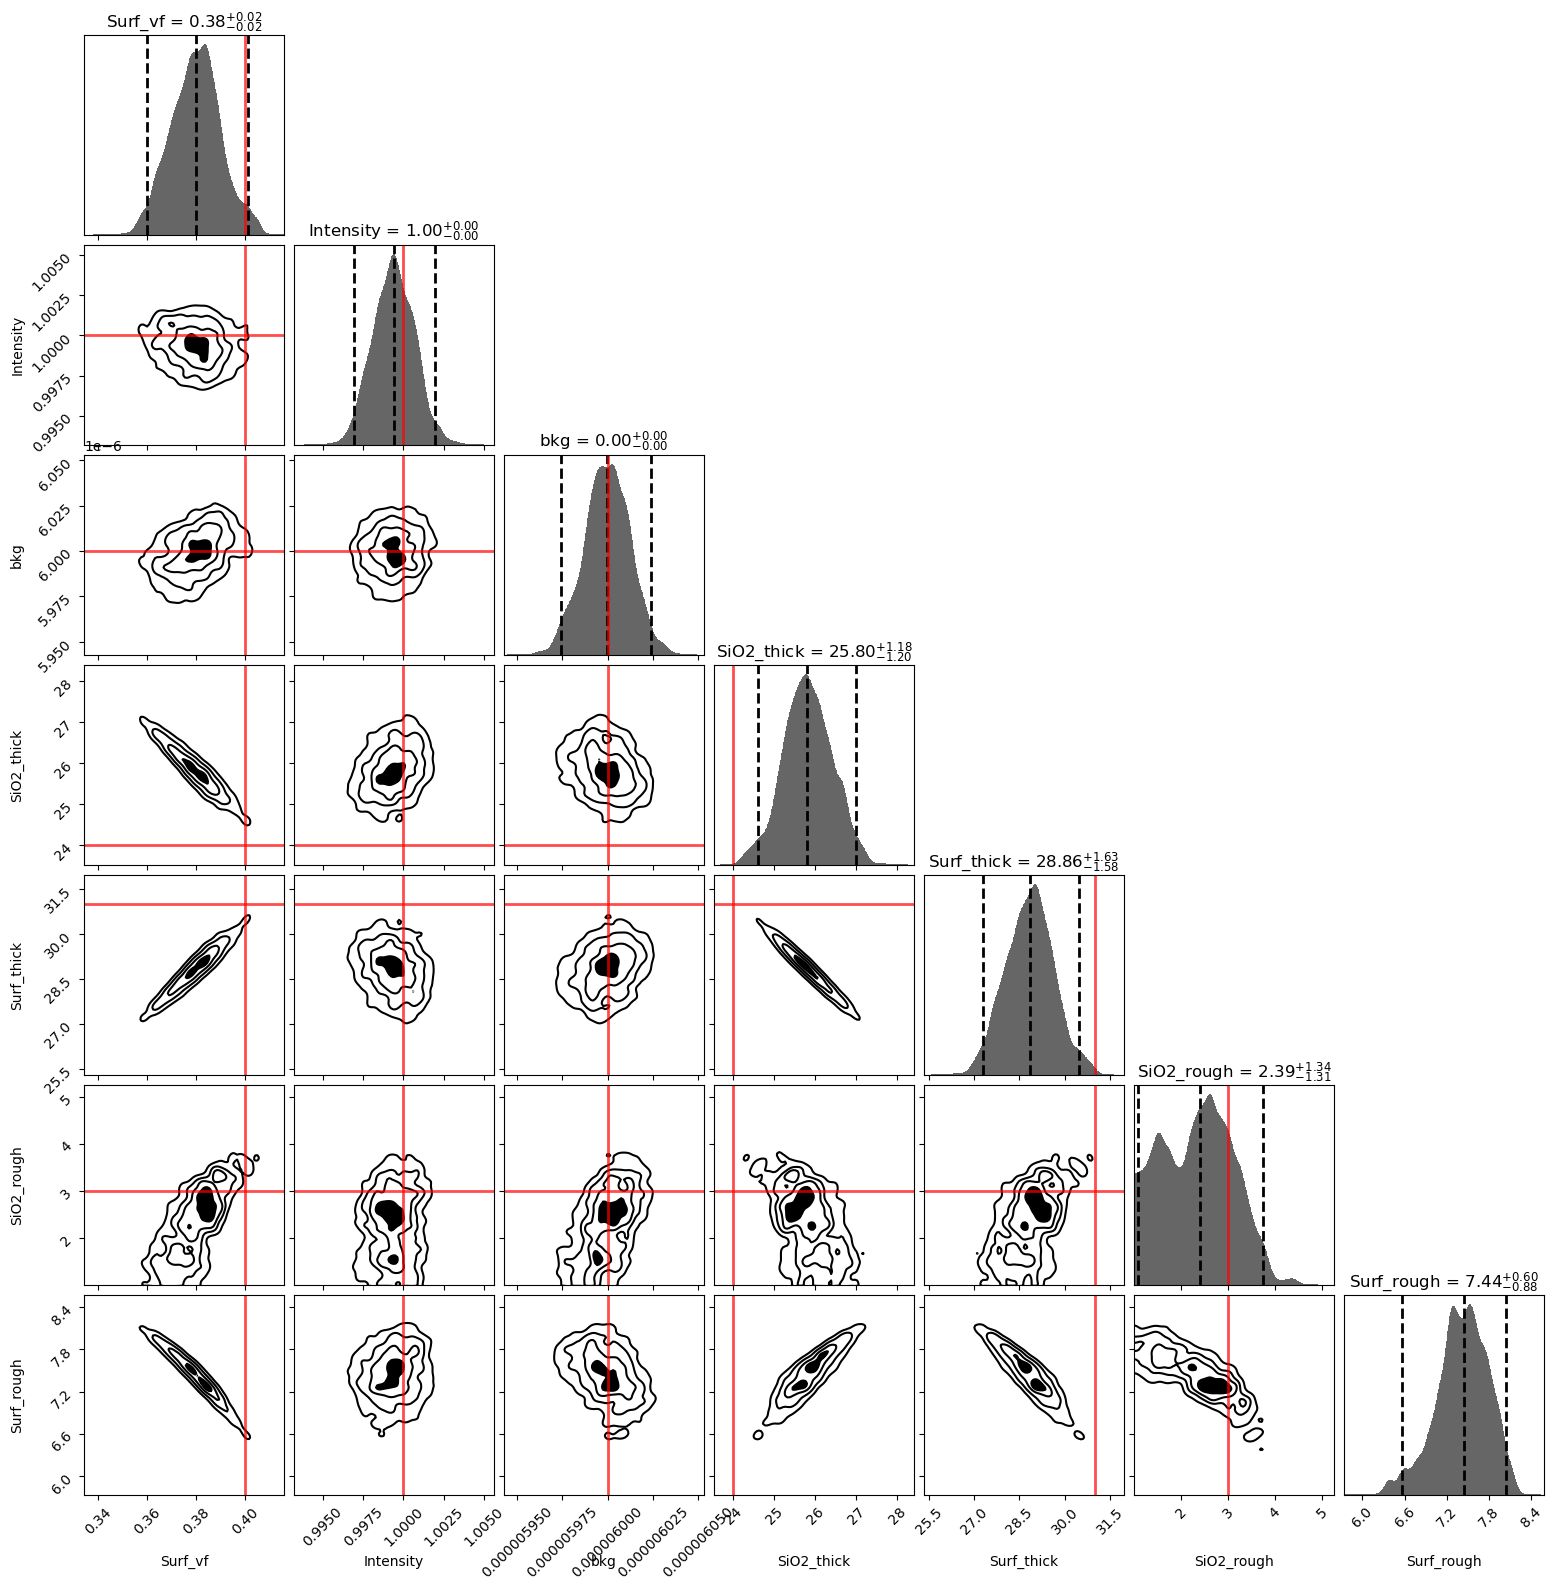

In [18]:
# In the conformal case, we have a more well-defined posterior, presumably because the number of parameters are lower.
# but notice the posterior doesn't include the original structure prior to adding noise 
# (truth value of surf_rough lies well outside the 1D marginalised posterior).

fig, axes = dyplot.cornerplot(res_load, show_titles=True, labels=labelz, truths=truthz)
plt.show()

Surf_vf
    Median: 3.8001E-01
    Lower: 3.5980E-01
    Upper: 4.0093E-01
    Minus: 2.0210E-02
    Plus: 2.0928E-02
Intensity
    Median: 9.9939E-01
    Lower: 9.9696E-01
    Upper: 1.0020E+00
    Minus: 2.4252E-03
    Plus: 2.5814E-03
bkg
    Median: 5.9999E-06
    Lower: 5.9743E-06
    Upper: 6.0240E-06
    Minus: 2.5591E-08
    Plus: 2.4125E-08
SiO2_thick
    Median: 2.5802E+01
    Lower: 2.4597E+01
    Upper: 2.6983E+01
    Minus: 1.2050E+00
    Plus: 1.1815E+00
Surf_thick
    Median: 2.8857E+01
    Lower: 2.7276E+01
    Upper: 3.0488E+01
    Minus: 1.5817E+00
    Plus: 1.6304E+00
SiO2_rough
    Median: 2.3941E+00
    Lower: 1.0875E+00
    Upper: 3.7385E+00
    Minus: 1.3065E+00
    Plus: 1.3445E+00
Surf_rough
    Median: 7.4400E+00
    Lower: 6.5625E+00
    Upper: 8.0381E+00
    Minus: 8.7756E-01
    Plus: 5.9801E-01
The number of effective samples via kish = 2886.689230754642


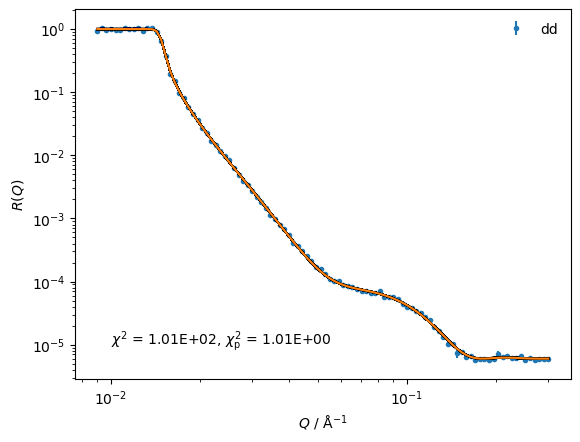

In [19]:
# lets take a look at the fit.
# this may take a few minutes.

from dynesty import utils as dyfunc
from functools import reduce

samples = res_load.samples  # samples explored by nested sampling.
weights = np.exp(res_load.logwt - res_load.logz[-1])  # normalized weights. These glob_obj from low to high.

# Compute 2.5%-97.5% quantiles.
quantiles = [dyfunc.quantile(samps, [0.025, 0.5, 0.975], weights=weights)
             for samps in samples.T]

#lets print out the posterior found by NS.
for i, j in enumerate(quantiles):
    print(f"""{labelz[i]}
    Median: {j[1]:.4E}
    Lower: {j[0]:.4E}
    Upper: {j[2]:.4E}
    Minus: {j[1]-j[0]:.4E}
    Plus: {j[2]-j[1]:.4E}""")

print(f'The number of effective samples via kish = {np.sum(weights)**2 / np.sum(weights**2)}')

posterior_samples = res_load.samples_equal()

idx_post_samps = np.arange(0, posterior_samples.shape[0])
idx_rpost_samps = np.random.choice(idx_post_samps, size=300, replace=False)
posterior_samples_plotting = posterior_samples[idx_rpost_samps]

logposts = [GO.logpost(i) for i in posterior_samples]

median_logpost = np.median(logposts)
index_of_logpost = np.where(median_logpost == logposts)[0][0]

GO.varying_parameters().pvals = posterior_samples[index_of_logpost]
saved_params = np.array(GO.parameters)

# lets plot the reflectivity, sld profiles and volume fraction profiles.
# first reflectivity:

chi2 = GO.chisqr()
chi2red = chi2/(GO.npoints)

fig, ax = plt.subplots()
for i in posterior_samples_plotting: # plot the posterior
    GO.varying_parameters().pvals = i # change the values of the varying parameters to the posterior samples.
    ax.plot(GO.objectives[0].data.x, GO.objectives[0].generative(), color='k', alpha=0.05, linewidth=1.5)
# plot the median reflectivity
GO.setp(saved_params)
ax.plot(GO.objectives[0].data.x, GO.objectives[0].generative(), color='tab:orange', zorder=2, linewidth=1.5)
# plot the data stored in the original objective.
ax.errorbar(GO.objectives[0].data.x, GO.objectives[0].data.y, yerr=GO.objectives[0].data.y_err, linestyle='None', marker='.', color='tab:blue', zorder=1, label='dd')
# formatting.
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel(r'$R\left(Q\right)$')
ax.set_xlabel(r'$Q$ / $\mathrm{\AA}^{-1}$')
ax.text(1E-2, 1E-5, f'$\chi^{2}$ = {chi2:.2E},' + r' $\chi^{2}_{\mathrm{p}}$ = ' + f'{chi2red:.2E}')
ax.legend(frameon=False)
plt.show()

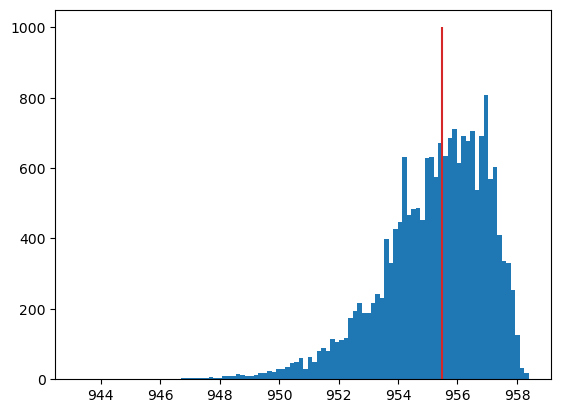

In [20]:
# what does the distribution of logposts look like?
# red line shows the median value, and this is the orange representation of the posterior we have used above.

plt.hist(logposts, bins=100)
plt.vlines(x=median_logpost, ymin=0, ymax=1000, color='tab:red')
plt.show()

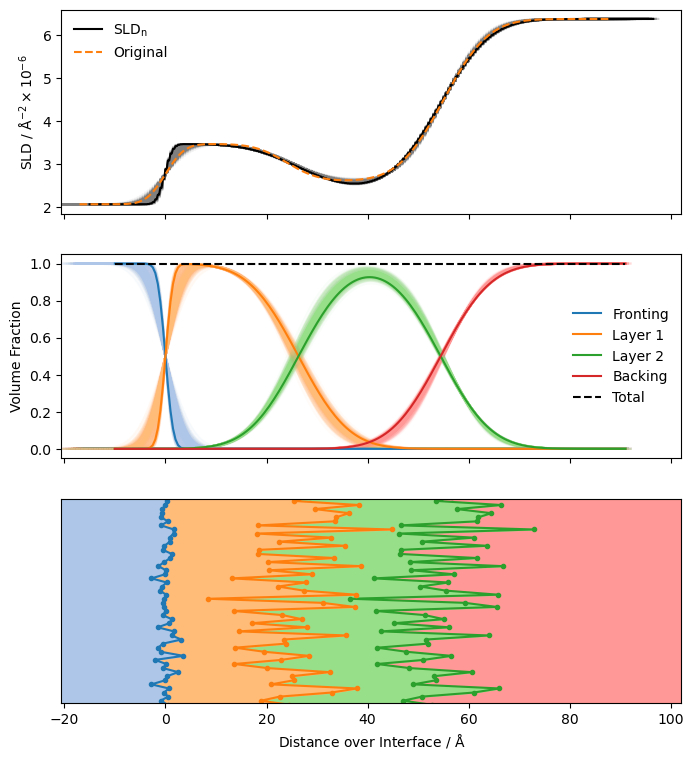

In [21]:
from matplotlib import colormaps

# finally, plot the SLD + volume fraction profile

#recover median values
GO.setp(saved_params)

#colours for posteriors
colours = colormaps['tab20'].colors

# we can get a quick plot from the VFP to show case the model of the interface.
fig, ax = GO.objectives[0].model.structure.components[1].plot()

# add posterior samples
for i in posterior_samples_plotting:
    GO.varying_parameters().pvals = i
    ax[0].plot(
                GO.objectives[0].model.structure.sld_profile(max_delta_z=0.1)[0]+GO.objectives[0].model.structure.components[1].SLD_offset(), 
                GO.objectives[0].model.structure.sld_profile(max_delta_z=0.1)[1], 
                color='tab:gray', alpha=0.05, zorder=0
                )
    ax[1].plot(
                GO.objectives[0].model.structure.components[1].z_and_SLD_scatter()[0],
                GO.objectives[0].model.structure.components[1].vfs_for_display()[0][0].T,
                color=colours[1], alpha=0.05, zorder=0
                )
    ax[1].plot(
                GO.objectives[0].model.structure.components[1].z_and_SLD_scatter()[0],
                GO.objectives[0].model.structure.components[1].vfs_for_display()[0][1].T,
                color=colours[3], alpha=0.05, zorder=0
                )
    ax[1].plot(
                GO.objectives[0].model.structure.components[1].z_and_SLD_scatter()[0],
                GO.objectives[0].model.structure.components[1].vfs_for_display()[0][2].T,
                color=colours[5], alpha=0.05, zorder=0
                )
    ax[1].plot(
                GO.objectives[0].model.structure.components[1].z_and_SLD_scatter()[0],
                GO.objectives[0].model.structure.components[1].vfs_for_display()[0][3].T,
                color=colours[7], alpha=0.05, zorder=0
                )

# plot original SLD profile before noise.
orig_SLD = np.loadtxt("Fake_Si_orig_SLD.dat").T
ax[0].plot(orig_SLD[0], orig_SLD[1], 
           label='Original',
           linestyle='--',
           color='tab:orange')

ax[0].legend(frameon=False)
plt.show()